### Helpers

In [1]:
# %load_ext autoreload
# %autoreload 2

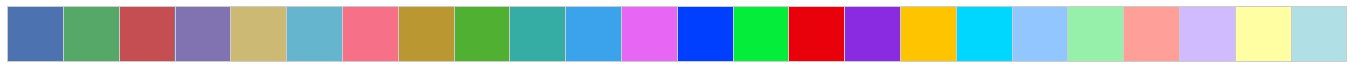

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from IPython.display import display
from common import *
from io_tools import (
    read_train, read_pub_test, read_pvt_test,
    convert_train, convert_pub_test, convert_pvt_test,
)
from pipeline import (
    split_classes, count_classes, sample,
    cross_validate, fit_predict_save, fit_save_model
)
from transformers.pca import pca_fit, pca_transform
from transformers.cosine import add_coses, to_degrees
from transformers.momentum import add_is_muon, add_is_muon_tight, add_probability_hit_detector
from transformers.err import add_mse, add_normed_err

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

### Reading

In [2]:
# derivative cols

In [3]:
%%time
used_cols = xyz_cols + mom_cols + hit_type_cols + dxyz_cols + exy_cols + edxy_cols
train = read_train(used_cols, 100000)
display(train.shape, count_classes(train))

(100000, 48)

(50000, 50000)

Wall time: 195 ms


### Data transformer

Это по сути основная часть. Класс, который отбирает нужные столбцы, возможно что-то модифицирует или добавляет. На выходе - входные данные для модели.

In [7]:
%%time
from sklearn.base import TransformerMixin

class DataTransformer(TransformerMixin):
    def __init__(self, *featurizers):
        self.featurizers = featurizers
    
    def fit(self, data, y=None):
        return self

    def transform(self, data):
        data = data.copy()
        self.origin_features = [] + xyz_cols #+ mom_cols + hit_type_cols + exy_cols + edxy_cols + dxyz_cols
        features = self.origin_features.copy()

#         add_is_muon(data, features)
#         add_is_muon_tight(data, features)
#         add_probability_hit_detector(data, features)
        add_coses(data, features)
        add_mse(data, features)
        add_normed_err(data, features)
        
        filter_data(data)
        
        if not features:
            raise('no features')
    
        self.features = features[len(self.origin_features):]
        return data[features].values

df_scores = cross_validate(train, n_estimators=60, n_splits=3, n_rows=1000, transformer_cls=DataTransformer)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,0.728989,0.683159,0.887765,0.772045,0.760788,0.565302,0.099689,0.0
std,0.017568,0.014959,0.022300,0.014706,0.052150,0.389213,0.023003,0.0
min,0.708709,0.666667,0.872093,0.755668,0.707858,0.266707,0.073225,0.0
25%,0.723724,0.676812,0.875000,0.766009,0.735122,0.345208,0.092084,0.0
50%,0.738739,0.686957,0.877907,0.776350,0.762386,0.423710,0.110944,0.0
75%,0.739130,0.691405,0.895601,0.780234,0.787254,0.714600,0.112920,0.0
max,0.739521,0.695853,0.913295,0.784119,0.812121,1.005491,0.114897,0.0


Wall time: 718 ms


### Test theory

In [63]:
%%time
df_scores = cross_validate(train, n_estimators=120, n_splits=5, n_rows=100000, transformer_cls=DataTransformer)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0
mean,0.763910,0.713573,0.881820,0.788817,0.802750,0.760467,0.063731,0.0
std,0.003236,0.004080,0.001524,0.002107,0.005221,0.040677,0.001939,0.0
min,0.758600,0.707212,0.879400,0.785231,0.795512,0.696763,0.060443,0.0
25%,0.764000,0.713075,0.881800,0.789192,0.799986,0.756284,0.063571,0.0
50%,0.764750,0.714529,0.881800,0.789401,0.804262,0.760043,0.064531,0.0
75%,0.764800,0.714587,0.882600,0.789436,0.804682,0.784392,0.064891,0.0
max,0.767400,0.718464,0.883500,0.790827,0.809306,0.804852,0.065221,0.0


Wall time: 1min 41s


### Get result

In [23]:
test = read_pub_test(used_cols)

In [30]:
%%time
fit_predict_save(sample(train, 100000), test, "out/08_cos_mse_nerr_100.csv", n_estimators=120, transformer_cls=DataTransformer)

C:\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in arccos
  from ipykernel import kernelapp as app
C:\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Wall time: 25.1 s


In [6]:
%%time
fit_save_model(sample(train, 100000), "models/07_dumb_cols.xgb", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 11.5 s


### Scratches

In [410]:
a = pd.DataFrame([[1.0, np.NaN], [np.NaN, np.NaN], [2.0, 3.1]], columns=['a', 'b'])

In [10]:
from transformers.cosine import da_cols
from transformers.err import err_cols

In [ ]:
def filter_data(data):
    
    
    return data

df_scores = cross_validate(train, n_estimators=60, n_splits=3, n_rows=1000, transformer_cls=DataTransformer)
display(df_scores.describe())

In [65]:
import numpy as np
from common import xy_cols, exy_cols, dx_cols, dy_cols, edxy_cols, N_STATIONS

err_cols = ['ErrMSE', 'Chi2Quantile']

nerr_x_cols = ['NErr_X[%i]' % i for i in range(N_STATIONS)]
nerr_y_cols = ['NErr_Y[%i]' % i for i in range(N_STATIONS)]
nerr_xy_cols = nerr_x_cols + nerr_y_cols


def add_mse(data, features):
    dxy = (data.loc[:, xy_cols].values - data.loc[:, exy_cols].values) / data.loc[:, dx_cols + dy_cols].values / 2.
    D = np.mean(dxy**2, axis=1)
    
    data.loc[:, err_cols[0]] = D
    features += [err_cols[0]]
    return data

def add_normed_err(data, features):
    dxy = data.loc[:, xy_cols].values - data.loc[:, exy_cols].values
    normed_errors = dxy / np.sqrt(data.loc[:, edxy_cols].values)
    
    for i in range(4):
        data.loc[:, nerr_x_cols[i]] = normed_errors[:, i]
        data.loc[:, nerr_y_cols[i]] = normed_errors[:, i + 4]
    
    features += nerr_xy_cols
    return data

In [134]:
dt = sample(train, 100000).copy()
dt = add_mse(dt, [])

DescribeResult(nobs=39524, minmax=(0.0033498798, 29.240831), mean=5.636588, variance=58.12808, skewness=1.4272383451461792, kurtosis=0.8939113089306718)

DescribeResult(nobs=43969, minmax=(0.004125464, 1.6598967), mean=0.32160887, variance=0.10578022, skewness=1.8635096549987793, kurtosis=3.251430118458636)

C:\Anaconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Anaconda3\envs\tf\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Anaconda3\envs\tf\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


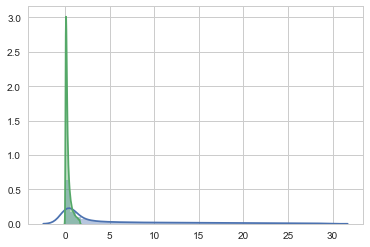

In [284]:
dts = [d[err_cols[0]].dropna() for d in split_classes(dt)]
for i in range(2):
    d = dts[i]
    dts[i] = d[d < d.quantile(.9)]

dt0 = dts[0].values
dt1 = dts[1].values

display(sts.describe(dt0))
display(sts.describe(dt1))
_ = sns.distplot(dt0)
_ = sns.distplot(dt1)

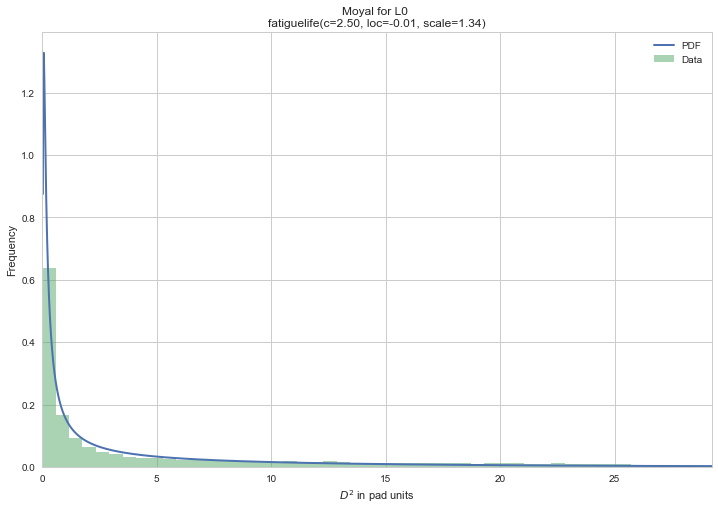

In [285]:
import warnings

def fit_moyal(data, bins):
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    
    params = sts.moyal.fit(x)

    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Calculate fitted PDF and error with fit in distribution
    pdf = sts.moyal.pdf(x, loc=loc, scale=scale, *arg)
    sse = np.sum(np.power(y - pdf, 2.0))
    
    return sts.moyal, params

def best_fit_distribution(data, bins=200):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [
        sts.fatiguelife,sts.foldcauchy,sts.loglaplace,sts.johnsonsu,

#         sts.f,sts.lognorm,sts.exponnorm,sts.fisk,sts.t,sts.powerlognorm,
#         sts.alpha,sts.burr,sts.pareto,sts.genextreme,sts.gilbrat,sts.wald,sts.weibull_min,
#         sts.johnsonsb,sts.lomax,sts.mielke,sts.recipinvgauss,
        
#         sts.anglit,sts.arcsine,sts.beta,sts.betaprime,sts.bradford,sts.cauchy,sts.chi,sts.chi2,sts.cosine,
#         sts.dgamma,sts.dweibull,sts.erlang,sts.expon,sts.exponweib,sts.exponpow,
#         sts.foldnorm,sts.frechet_r,sts.frechet_l,sts.genlogistic,sts.genpareto,sts.gennorm,sts.genexpon,
#         sts.gompertz,sts.gumbel_r,sts.gausshyper,sts.gamma,sts.gengamma,sts.genhalflogistic,
#         sts.gumbel_l,sts.halfcauchy,sts.halflogistic,sts.halfnorm,sts.halfgennorm,sts.hypsecant,sts.invgamma,sts.invgauss,
#         sts.invweibull,sts.kstwobign,sts.laplace,sts.levy, sts.levy_l,
#         sts.logistic,sts.loggamma, sts.maxwell, sts.nakagami,
#         sts.norm,sts.pearson3,sts.powerlaw,sts.powernorm,sts.rdist,sts.reciprocal,
#         sts.rayleigh,sts.rice,sts.semicircular,sts.triang,sts.truncexpon,sts.truncnorm,
#         sts.uniform,sts.vonmises,sts.vonmises_line,sts.weibull_max,sts.wrapcauchy, sts.moyal
    ]

    # Best holders
    best_distribution = sts.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Ignore warnings from data that can't be fit
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')

            # fit dist to data
            params = distribution.fit(data)

            # Separate parts of parameters
            arg = params[:-2]
            loc = params[-2]
            scale = params[-1]

            # Calculate fitted PDF and error with fit in distribution
            pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
            sse = np.sum(np.power(y - pdf, 2.0))

            # identify if this distribution is better
            if best_sse > sse > 0:
                best_distribution = distribution
                best_params = params
                best_sse = sse

    return (best_distribution, best_params)
    
def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

def fit_params(data):
    # Find best fit distribution
    best_dist, best_fit_params = best_fit_distribution(data, 100)
    # Make PDF with best params 
    pdf = make_pdf(best_dist, best_fit_params)

    # Display
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True, xlim=(0, data.max()))
    data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_dist.name, param_str)
    
    # Update plots
    ax.set_title(u'Moyal for L0 \n' + dist_str)
    ax.set_xlabel(u'$D^2$ in pad units')
    ax.set_ylabel('Frequency')    
    
df_dt0 = pd.Series(dt0, name='L0')
fit_params(df_dt0)

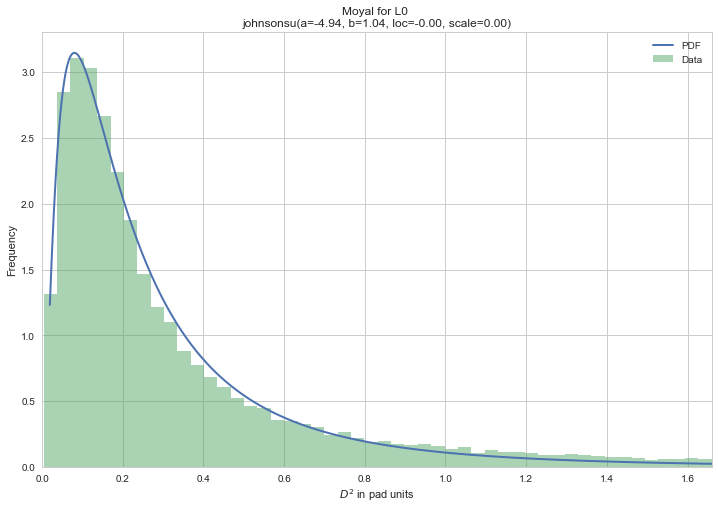

In [286]:
df_dt1 = pd.Series(dt1, name='L1')
fit_params(df_dt1)

In [ ]:
sts.johnsonsu()

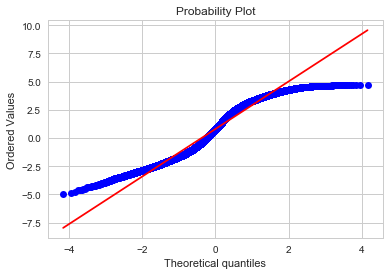

In [142]:
_ = sts.probplot(sts.boxcox(dt0)[0], plot=plt)

In [69]:
dts[1].describe()

count    48855.000000
mean         1.415865
std          6.012142
min          0.004125
25%          0.115471
50%          0.230312
75%          0.562170
max        122.150024
Name: ErrMSE, dtype: float64

C:\Anaconda3\envs\tf\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Anaconda3\envs\tf\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


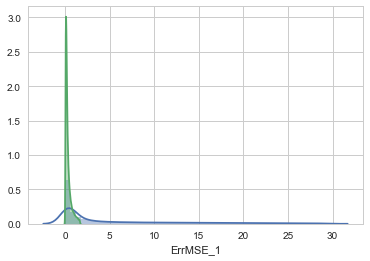

In [89]:
for i in range(2):
    d = dts[i]
    dd = d[d < d.quantile(.9)]
    dd.name += '_{0}'.format(i)
    t = sns.distplot(dd)
#     dd.hist()

t